In [2]:
import sys
sys.path.insert(0, '..')
from eda_import import *
from matplotlib.colors import LinearSegmentedColormap

In [3]:
%%time 
TOTAL_NUM_CALLS = 67544140
_cols = ['analysis_id', 'barcode', 'disease', 'sstype', 'mkid', 'seqname', 'gene_name',
         'strand', 'participant_id', 'mclv', 'aclv']
adf = pd.read_csv('../__results/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv.gz',
                  compression='gzip', usecols=_cols)

CPU times: user 15.2 s, sys: 588 ms, total: 15.8 s
Wall time: 15.8 s


In [4]:
bdf = adf.drop_duplicates()
assert bdf.shape[0] == 2213818
assert bdf.mkid.unique().shape[0] == 2136

In [5]:
NT_diseases = [
    'BRCA',
    'KIRC', 'COAD', 'KIRP', 'LIHC', 'LUAD', 'LUSC', 'THCA', 'HNSC', 'STAD',
    'KICH', 
    'UCEC',
    'PRAD', 'BLCA'
]

First needs to generate tsne coordinates, then plot 2D distributions in hexagons bins 

In [6]:
pat_df = bdf.groupby('participant_id').apply(lambda g: g.sstype.unique().shape[0] > 1)
pats = pat_df[pat_df].reset_index().participant_id.unique()

In [7]:
%%time
for dise in NT_diseases:
    print('working on {0}'.format(dise), end=', ')
    rdf = bdf.query('disease == "{0}"'.format(dise)).copy()
    sstype_le = LabelEncoder()
    sstype_le.fit(rdf.sstype.unique())

    rdf['sstype_enc'] = sstype_le.transform(rdf.sstype)
    mkid_le = LabelEncoder()
    mkid_le.fit(rdf.mkid.unique())
    rdf['mkid_enc'] = mkid_le.transform(rdf.mkid)
    
    enc = OneHotEncoder()
    enc.fit(rdf.mkid_enc.values.reshape(-1, 1))

    X_list, y_list, patid_list, barcode_list, aid_list = [], [], [], [], []
    for k, g in rdf.groupby(['participant_id', 'sstype', 'barcode', 'analysis_id']):
        X_list.append(enc.transform(g.mkid_enc.values.reshape(-1, 1)).sum(axis=0))
        _vals = g.sstype_enc.unique()
        _ids = g.participant_id.unique()
        _bcs = g.barcode.unique()
        _aids = g.analysis_id.unique()
        for _s in [_vals, _ids, _bcs, _aids]: assert _s.shape[0] == 1
        y_list.append(_vals[0])
        patid_list.append(_ids[0])
        barcode_list.append(_bcs[0])
        aid_list.append(_aids[0])

    X = np.vstack(X_list)
    ys = np.array(y_list)
    patids = np.array(patid_list)
    barcodes = np.array(barcode_list)
    aids = np.array(aid_list)
    
    uniq_y = np.unique(ys)
    dd = dict(zip(uniq_y, sstype_le.inverse_transform(uniq_y)))
    dd_df = pd.DataFrame.from_dict(dd, orient='index')
    dd_df.columns = ['sstype']

    X_reduced = TruncatedSVD(n_components=50,  algorithm='arpack', random_state=0).fit_transform(X)
    # random_state = np.random.randint(0, 1e9)
    random_state = 0
    
    if dise == 'KICH':
        prp = 15
        lr = 30
    elif dise == 'UCEC':
        prp = 25
        lr = 100
    elif dise == 'BRCA':
        prp = 40
        lr = 500
    else:
        prp = 40
        lr = 300
    X_embedded = TSNE(n_components=2, perplexity=prp, learning_rate=lr,
                      random_state=random_state, verbose=False).fit_transform(X_reduced)

    df_embedded = pd.DataFrame(X_embedded)
    df_embedded['y'] = ys
    df_embedded['participant_id'] = patids
    df_embedded['barcode'] = barcodes
    df_embedded['analysis_id'] = aids
    df_embedded = df_embedded.merge(dd_df, left_on='y', right_index=True)

    fig = plt.figure(figsize=(16, 13))
    ax = fig.add_subplot(1, 1, 1)
    colors_dd = {
        'normal': 'blue',
        'tumour': 'red'
    }
    for st in df_embedded.sstype.unique():
        df_embedded[df_embedded.sstype == st].plot.scatter(
            x=0, y=1, color=colors_dd[st], s=25, ax=ax, edgecolor='none', label=st.capitalize())

    for k, grp in df_embedded.query('participant_id in {0}'.format(pats.tolist())).groupby('participant_id'):
        grp.plot(x=0, y=1, ax=ax, lw=0.1, color='gray', legend=False)

    ax.set_xlim([-12, 12]) 
    ax.set_ylim([-12, 12])
    ax.set_title('{0}'.format(dise), fontsize=20)
    ax.set_xlabel('t-SNE 1', fontsize=20)
    ax.set_ylabel('t-SNE 2', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    outdir = '../__results/figs/tsne/NT/'
    
    # just make plot on the way
    out_fig = os.path.join(outdir, '{0}-rs-{1}.jpg'.format(dise, random_state))
    plt.savefig(out_fig, bbox_inches='tight', dpi=200)
    fig.clf()
    plt.close(fig)
    
    # the csv is what's needed to plot 2D hexagons
    out_csv = os.path.join(outdir, '{0}-rs-{1}.csv'.format(dise, random_state))
    df_embedded.to_csv(out_csv, index=False)

working on BRCA, working on KIRC, working on COAD, working on KIRP, working on LIHC, working on LUAD, working on LUSC, working on THCA, working on HNSC, working on STAD, working on KICH, working on UCEC, working on PRAD, working on BLCA, CPU times: user 7min 50s, sys: 23.8 s, total: 8min 14s
Wall time: 1min 16s


# Density plot

In [9]:
MONO_COLOR = [(0.0,  1.0, 1.0),
              (1.0,  1.0, 1.0)]
NONE_COLOR =  [(0,0,0),
               (1,0,0)]
ALPHA_GRADIENT = [(0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0)]

def gen_colbar(sstype):
    # learned from http://stackoverflow.com/questions/31575400/how-to-fade-color-to-transparent-using-hexbin-and-matplotlib
    # API: http://matplotlib.org/api/colors_api.html#matplotlib.colors.LinearSegmentedColormap
    if sstype == 'normal':
        red = NONE_COLOR
        blue = MONO_COLOR
    elif sstype == 'tumour':
        blue = NONE_COLOR
        red = MONO_COLOR        
    green = NONE_COLOR
    cdict = {'red': red,
             'green': green,
             'blue': blue,
             'alpha': ALPHA_GRADIENT
            }
    colbar = LinearSegmentedColormap('Dropout', cdict)
    return colbar

working on KIRC,working on LUAD,working on BRCA,working on HNSC,

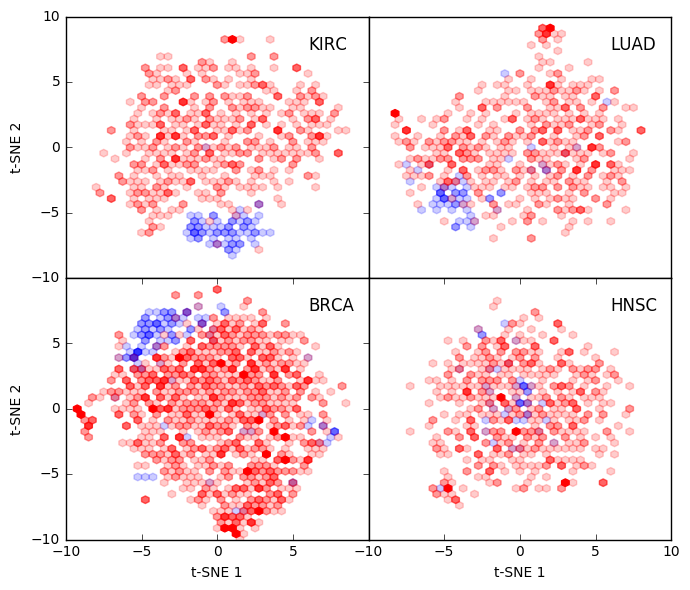

In [13]:
den_dise = ['KIRC', 'LUAD', 'BRCA', 'HNSC']
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(7, 6), gridspec_kw={'hspace': 0, 'wspace': 0})
# ax = fig.add_subplot(111, aspect='equal')
axes = axes.ravel()

gridsize = 40
xlim = ylim = [-10, 10]
lim = 10
bins = np.arange(*xlim, 2)

for k, dise in enumerate(den_dise):
    print('working on {0}'.format(dise), end=',')
    tsne_df = pd.read_csv('../__results/figs/tsne/NT/{0}-rs-0.csv'.format(dise))
    # zero mean
    tsne_df['0'] = tsne_df['0'] - tsne_df['0'].mean()
    tsne_df['1'] = tsne_df['1'] - tsne_df['1'].mean()
    ax = axes[k]
    
    for st in ['normal', 'tumour']:
        colbar = gen_colbar(st)
        plt.register_cmap(cmap=colbar)
        xs, ys = tsne_df.query('sstype == "{0}"'.format(st))[['0','1']].T.values
        
        # using extent will make sure the shape of hexagon is regular,
        # http://stackoverflow.com/questions/8460627/making-hexbin-in-matplotlib-python-fill-in-empty-space-on-a-square-axis
        _ = ax.hexbin(xs, ys, gridsize=gridsize, vmin=0, vmax=5, cmap=colbar, extent=[-lim, lim, -lim, lim])
    ax.text(6, 7.5, dise, fontsize=12)

    if k in [0, 2]:
        ax.set_ylabel('t-SNE 2')
    if k in [2, 3]:
        ax.set_xlabel('t-SNE 1')

    if k == 0:
        ax.set_xticks([])
        ax.set_yticks(np.arange(-10, 11, 5))
    elif k == 1:
        ax.set_xticks([])
        ax.set_yticks([])
    elif k == 2:
        ax.set_xticks(np.arange(-10, 10, 5))
        ax.set_yticks(np.arange(-10, 10, 5))
    elif k == 3:
        ax.set_xticks(np.arange(-10, 11, 5))
        ax.set_yticks([])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.tight_layout()
# plt.savefig('../__results/figs/quad_NT.jpg', dpi=500)

# Plot the rest diseases

In [14]:
rest_diseases = sorted([_ for _ in NT_diseases if _ not in den_dise])
len(rest_diseases)

10

working on BLCA,working on COAD,working on KICH,working on KIRP,working on LIHC,working on LUSC,working on PRAD,working on STAD,working on THCA,working on UCEC,

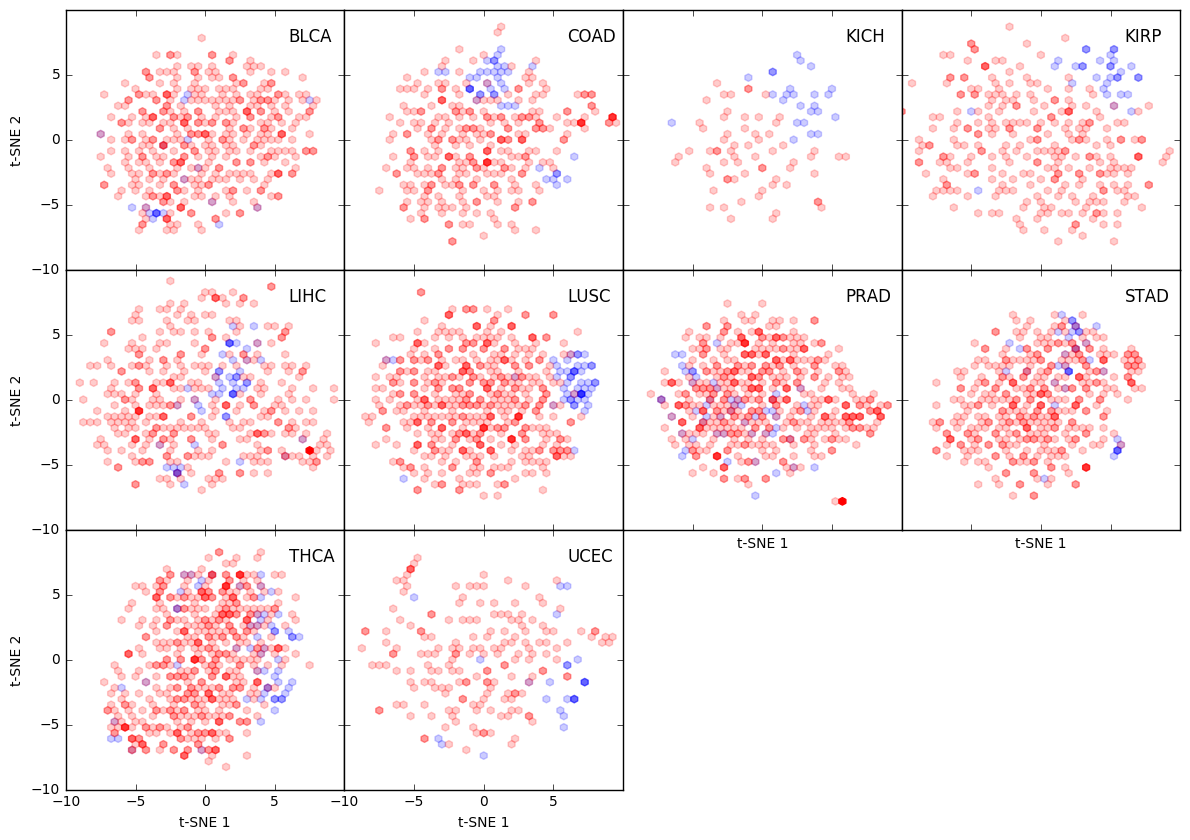

In [17]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 8.5), gridspec_kw={'hspace': 0, 'wspace': 0})
# ax = fig.add_subplot(111, aspect='equal')
axes = axes.ravel()

gridsize = 40
xlim = ylim = [-10, 10]
lim = 10
bins = np.arange(*xlim, 2)

for k, dise in enumerate(rest_diseases):
    print('working on {0}'.format(dise), end=',')
    tsne_df = pd.read_csv('../__results/figs/tsne/NT/{0}-rs-0.csv'.format(dise))
    # zero mean
    tsne_df['0'] = tsne_df['0'] - tsne_df['0'].mean()
    tsne_df['1'] = tsne_df['1'] - tsne_df['1'].mean()
    ax = axes[k]
    
    for st in ['normal', 'tumour']:
        colbar = gen_colbar(st)
        plt.register_cmap(cmap=colbar)
        xs, ys = tsne_df.query('sstype == "{0}"'.format(st))[['0','1']].T.values
        
        # using extent will make sure the shape of hexagon is regular,
        # http://stackoverflow.com/questions/8460627/making-hexbin-in-matplotlib-python-fill-in-empty-space-on-a-square-axis
        _ = ax.hexbin(xs, ys, gridsize=gridsize, vmin=0, vmax=5, cmap=colbar, extent=[-lim, lim, -lim, lim])
    ax.text(6, 7.5, dise, fontsize=12)

    if k % 4 == 0:
        ax.set_ylabel('t-SNE 2')
    if k + 1 >= 7:
        ax.set_xlabel('t-SNE 1')

    ax.set_xticks(np.arange(-10, 10, 5))
    ax.set_yticks(np.arange(-10, 10, 5))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
for i in axes[-2:]:
    i.patch.set_facecolor('white')
    i.axis('off')
plt.tight_layout()
# plt.savefig('../__results/figs/10_dises_NT.jpg', dpi=500)

### Single disease debugging

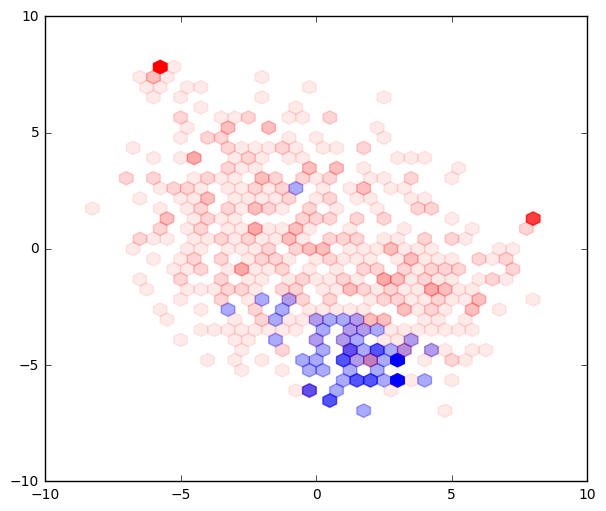

In [234]:
dise = 'LUAD'
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7, 6))

gridsize = 40
xlim = ylim = [-10, 10]
bins = np.arange(*xlim, 2)


tsne_df = pd.read_csv('/projects/btl/zxue/tasrkleat-TCGA-results/hexamer-patch/condp07.1/figs/tsne-CS-profile-NT/{0}-rs-0.csv'.format(dise))
# zero mean
tsne_df['0'] = tsne_df['0'] - tsne_df['0'].mean()
tsne_df['1'] = tsne_df['1'] - tsne_df['1'].mean()

for st in ['normal', 'tumour']:
    colbar = gen_colbar(st)
    plt.register_cmap(cmap=colbar)
    xs, ys = tsne_df.query('sstype == "{0}"'.format(st))[['0','1']].T.values
    _ = ax.hexbin(xs, ys, gridsize=40, cmap=colbar, extent=[-10, 10, -10, 10])
#     break
# ax.text(6, 9, dise)
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)